# Task 3.1 - Introduction of Noise to Observed Dynamics

In [2]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [8]:
%matplotlib notebook

## Generate Training Data

In [33]:
N = 512 * 2

np.random.seed(4)

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )

pad0 = lambda p : np.pad( p, (0,1) )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action_RK4( pad0(state) )[:4] - state for state in initial_states ] )

## Find Linear Least Squares Fit

In [34]:
Xplus = np.linalg.inv(X.T @ X) @ X.T
C = Xplus @ Y

## Scatter Plots

<IPython.core.display.Javascript object>


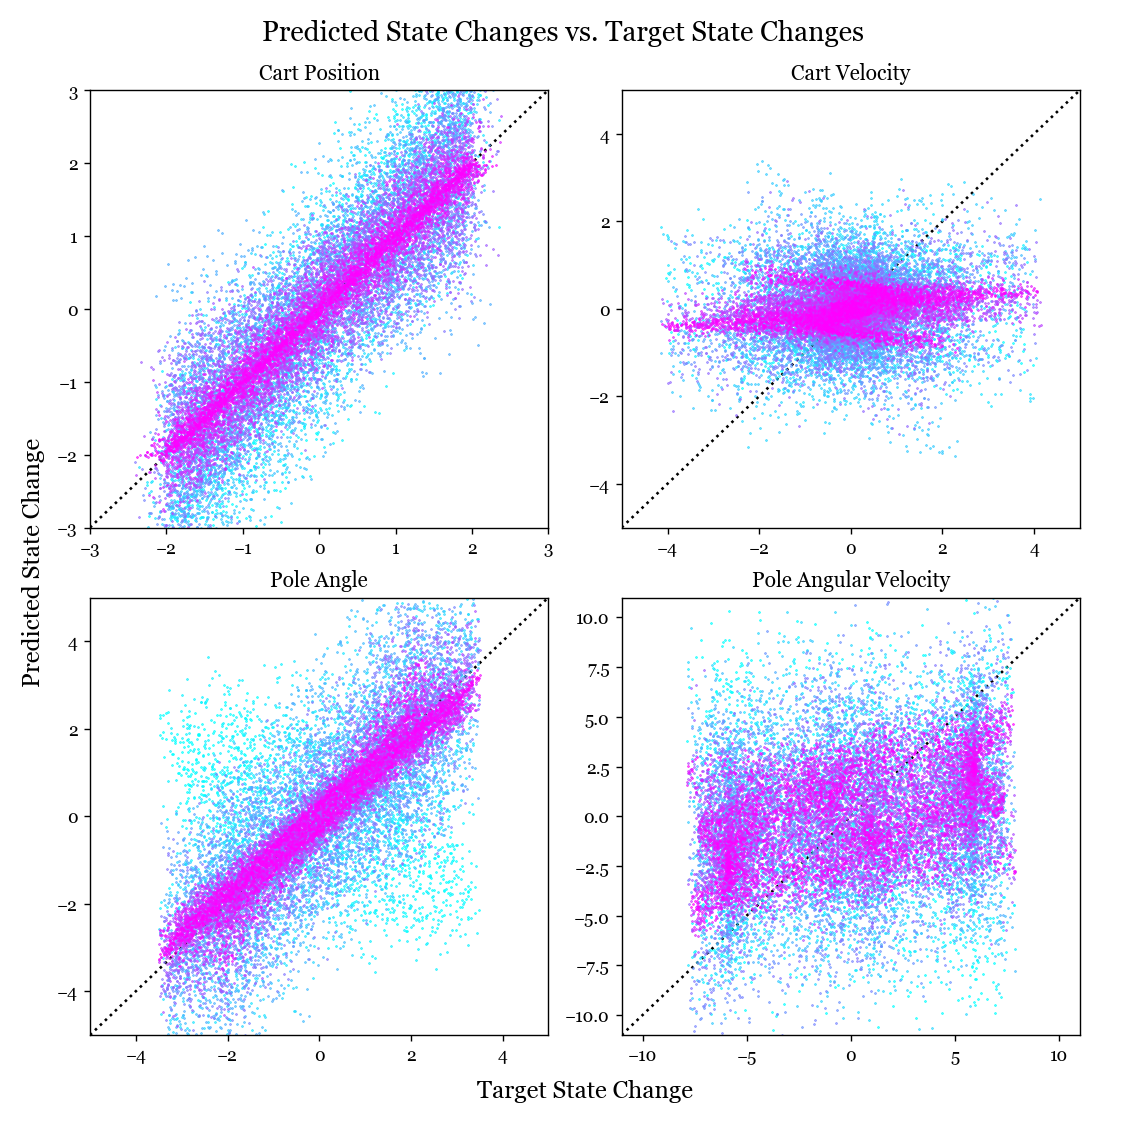

Text(0.03, 0.5, 'Predicted State Change')

In [129]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=19, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )

extents = np.array([ 3, 5, 5, 11 ])

pad0 = lambda p : np.pad( p, (0,1) )


N = 512 * 2

np.random.seed(4)


for j in range(20):    
    
    # get N initial states spaced in the recommended ranges
    X = initial_states = ( np.random.rand( N, 4 ) - 0.5 ) * 2 * np.array( [ 10, 10, np.pi, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( pad0(state) )[:4] - state for state in initial_states ] )

    noise_level = (19-j) * 1.05
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)

    Xplus = np.linalg.inv(X.T @ X) @ X.T
    C = Xplus @ Yn

    XC = X @ C

    for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

        x, y = XC[:,i], Y[:,i]

        ax.scatter( y, x, s=0.2, color=colours[j], zorder=2 )
        
        if j > 0:
            continue

        extent = extents[i]
        
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)

        ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )

        ax.set_title( titles[i] )
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

## Linear Model Accuracy with Varying Observation Noise

Above are scatter plots of the predicted state change against target state change for linear models fitted with varying amounts of observation noise. Magenta represents models fit with little noise, and cyan with a lot of noise added. The cart position and pole angle plots show improved prediction accuracy with less noise, as does the cart velocity plot although the linear model can't acheive a very good fit for this variable even with zero noise. The pole angular velocity plot shows bad predictions for all noise levels so I suppose is less sensitive to noise. Also note that I scaled the noise for each variable based on the average magnitude of the points in the plots to make the comparison more fair.

<IPython.core.display.Javascript object>


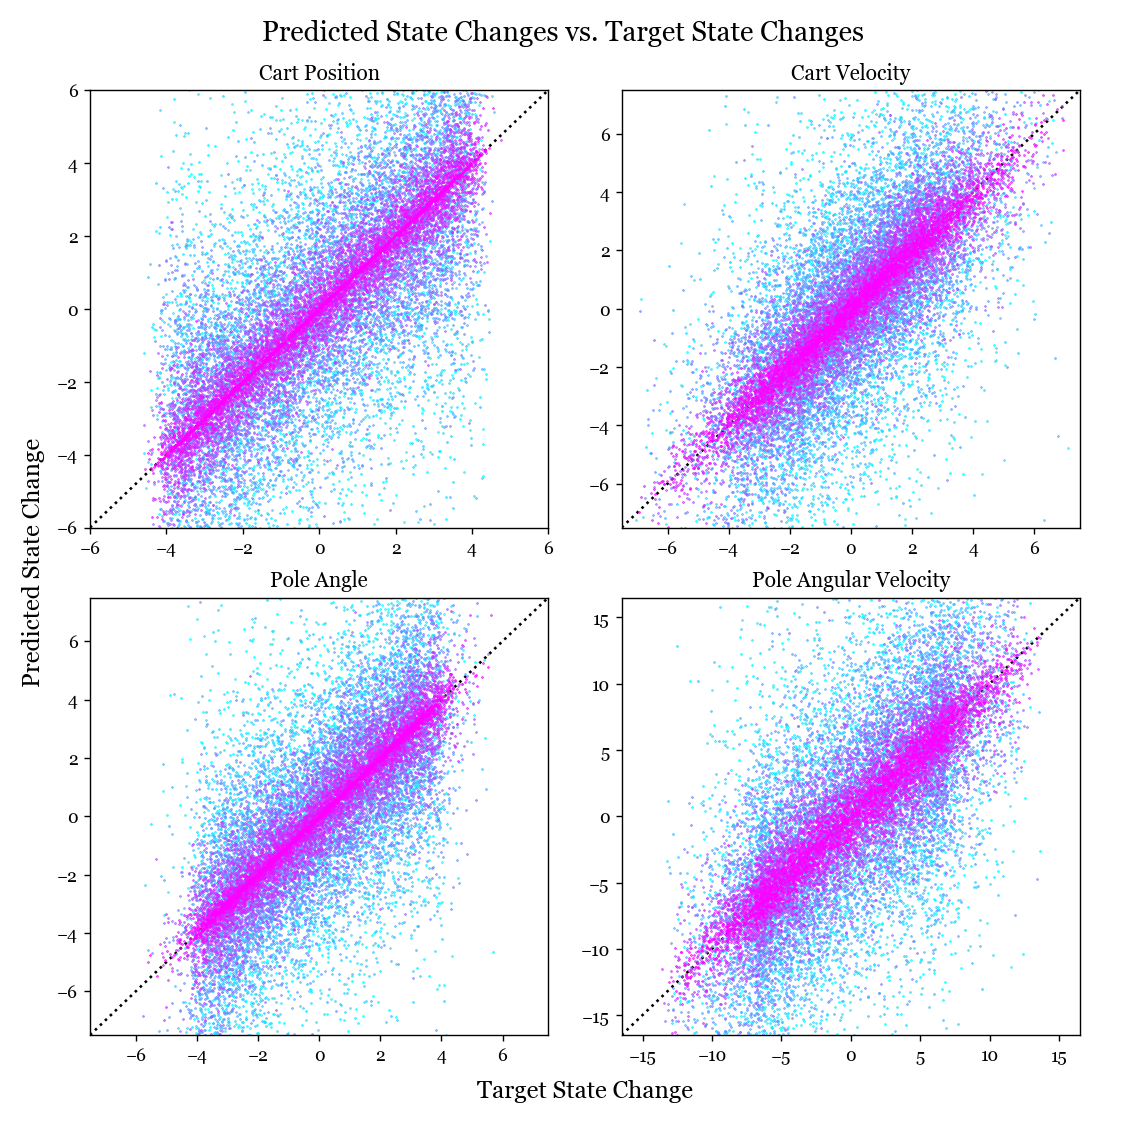

Text(0.03, 0.5, 'Predicted State Change')

In [116]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=21, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )

extents = np.array([ 4, 5, 5, 11 ]) * 1.5

pad0 = lambda p : np.pad( p, (0,1) )

np.random.seed(4)


for j in range(20):    
    
    N = 512 * 8

    # set the random seed and create the sobol sequence generator
    sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=j )

    # get N initial states spaced in the recommended ranges
    X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )

    
    noise_level = (19-j) * 0.25
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)    

    
    M = 32 * 32
    kernel_centres = X[:M]


    sigma = np.std( X, axis=0 )

    def K( X, Xp, sigma = sigma ):

        # get squared differences and substitute angle one for periodic version
        d2 = ( (X - Xp) / sigma ) ** 2
        d2[:,0] = 0
        d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

        # divide rows by 2 sigma and return exponential of negative sum along rows
        return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Yn

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

    def nonlinear_model( state ):

        kernels = K( state[np.newaxis], kernel_centres )

        weighted_sums = kernels @ alpha_m

        return weighted_sums.squeeze()

    
    # generate the changes in state from these states
    predictions = np.array( [ nonlinear_model( state ) for state in initial_states ] )
    
    
    for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

        x, y = predictions[:1024,i], Y[:1024,i]

        ax.scatter( y, x, s=0.2, color=colours[j], zorder=2 )
        
        if j > 0:
            continue

        extent = extents[i]
        
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)

        ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )

        ax.set_title( titles[i] )
    
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

## Effect of Noise on the Nonlinear Model

Above is the same plot, but using the nonlinear model rather than the linear model. Again the low noise scenario in magenta shows better predictions than the cyan noisy scenario, but this time the zero noise predictions are much better. Interestingly the above plots have one quarter as much noise added as those using the linear model, but still show similar deviation from the ideal line. This indicates that the nonlinear model is more sensitive to noise. I think this makes sense - for a linear function, the noise on either side of the desired fit almost cancels out so that the desired fit is less affected. The nonlinear model is actually able to fit to the noise which means its predictions of the true dynamics are worse.

In [136]:

linear_errors = []
nonlinear_errors = []

for j in range(20):
    
    N = 512 * 8

    # set the random seed and create the sobol sequence generator
    sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=j )

    # get N initial states spaced in the recommended ranges
    X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )

    
    noise_level = (19-j)
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)    

    
    M = 32 * 32
    kernel_centres = X[:M]
    
    
    # linear fit
    
    Xl = X[:1024]
    Ynl = Yn[:1024]
    
    Xplus = np.linalg.inv(Xl.T @ Xl) @ Xl.T
    C = Xplus @ Ynl

    
    # nonlinear fit

    sigma = np.std( X, axis=0 )

    def K( X, Xp, sigma = sigma ):

        # get squared differences and substitute angle one for periodic version
        d2 = ( (X - Xp) / sigma ) ** 2
        d2[:,0] = 0
        d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

        # divide rows by 2 sigma and return exponential of negative sum along rows
        return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Yn

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

    def nonlinear_model( state ):

        kernels = K( state[np.newaxis], kernel_centres )

        weighted_sums = kernels @ alpha_m

        return weighted_sums.squeeze()

    
    # get the predictions
    
    linear_predictions = X @ C
    nonlinear_predictions = np.array( [ nonlinear_model( state ) for state in initial_states ] )
    
    
    # evaluate the models
    
    linear_error    = np.sum( np.linalg.norm(    linear_predictions - Y, axis=1 ) )
    nonlinear_error = np.sum( np.linalg.norm( nonlinear_predictions - Y, axis=1 ) )
    
    linear_errors.append( linear_error )
    nonlinear_errors.append( nonlinear_error )

([40142.40417109749,
  35164.74195019638,
  28271.02480744733,
  32312.125245659983,
  27286.552651708236,
  34527.49441263694,
  25878.927668301145,
  29682.06003713867,
  26555.279946779177,
  26027.29952225611,
  23833.649814030214,
  22196.670530845753,
  21065.272696975342,
  21311.212037084,
  21323.373707462433,
  20885.825520472063,
  20802.159330614562,
  20162.700160985412,
  20056.34561558296,
  20040.21717042622],
 [166631.4856539178,
  160766.27624322055,
  148519.85102117632,
  146620.6330351745,
  136028.19939705794,
  122747.24512682739,
  115151.90948157888,
  109227.3392241818,
  99434.42429326079,
  88569.72349279674,
  80000.53263666484,
  71045.92410695704,
  63695.04877404067,
  52913.1508077387,
  45181.22324462225,
  35420.4094508175,
  26531.325683778625,
  18372.807137141554,
  9655.616026321166,
  3489.512254756893])

<IPython.core.display.Javascript object>


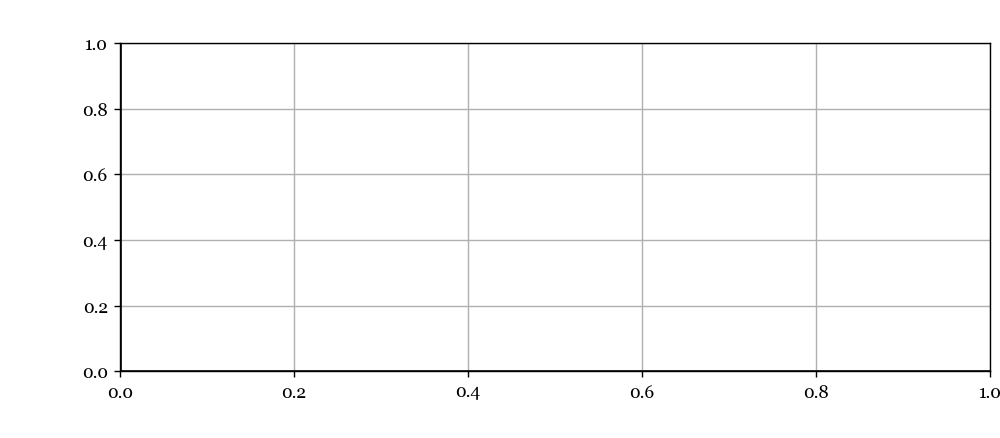

ValueError: x and y arrays must be equal in length along interpolation axis.

In [184]:
fig, ax = plt.subplots(1, 1, num=66, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.12, right=0.99)
sf3utility.setup_phase_portrait( ax )

j = np.arange( 20 )
x = noise_level = (19-j)

y1 = np.array( linear_errors )
y2 = np.array( nonlinear_errors )

f1 = scipy.interpolate.interp1d( x, y1, kind='cubic' )
f2 = scipy.interpolate.interp1d( x, y2, kind='cubic' )

xnew = np.linspace(x[0], x[-1], 800)

ax.plot( xnew, f1(xnew), color="magenta", label="Linear Model", linewidth=2 )
ax.plot( xnew, f2(xnew), color="cyan", label="Nonlinear Model", linewidth=2 )


ax.set_title( "Impact of Noise on Linear and Nonlinear Model Predictions" )
ax.set_xlabel( "Noise Multiplier" )
ax.set_ylabel( "Sum of Squared Errors" )
ax.legend(loc="upper left")

The above plot shows how the sum of squared errors varies with the noise level for the linear and nonlinear models. The linear model is more resistant to the noise, while the nonlinear model is linearly impacted by the noise although its initial squared error is lower. So there is a crossover point where the optimal model flips from the nonlinear one to the linear one.

In [187]:
ls = np.logspace( -4, 3, num=20, base=2 )
noise_levels = np.linspace( 0, 2, num=20 )

errors = np.zeros( (20, 20) )

N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


# nonlinear fit

sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):

    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):

    Kmn[i] = K( X, kernel_centre[np.newaxis] )

# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):

    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


KmnKnm = Kmn @ Kmn.T

means = np.mean(np.abs(Y), axis=0)


for j, noise_level in enumerate( noise_levels ):
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * means   
    b = Kmn @ Yn
        
        
    for i, l in enumerate(ls):

        a = KmnKnm + l * Kmm

        alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

        
        def nonlinear_model( state ):

            kernels = K( state[np.newaxis], kernel_centres )

            weighted_sums = kernels @ alpha_m

            return weighted_sums.squeeze()


        # get the predictions

        nonlinear_predictions = np.array( [ nonlinear_model( state ) for state in initial_states ] )


        # evaluate the models

        nonlinear_error = np.sum( np.linalg.norm( nonlinear_predictions - Y, axis=1 ) )    
        errors[i, j] = nonlinear_error
        
        print( j, nonlinear_error )

0 4411.055557812475
0 4492.468853052864
0 4579.85748171683
0 4675.113590698504
0 4780.410818305709
0 4898.110890031912
0 5031.108109637589
0 5182.186606545585
0 5353.786549457947
0 5549.551305974932
0 5775.964743473898
0 6041.82168984308
0 6356.594120826921
0 6733.25096484196
0 7187.839218970098
0 7730.73765980479
0 8373.889641915535
0 9117.603851813341
0 9951.86548501917
0 10861.092303062822
1 4459.604632685017
1 4537.752890808677
1 4622.303078774943
1 4714.873400685596
1 4817.164267705573
1 4932.005379250684
1 5062.872836381424
1 5211.98404726349
1 5381.788761929184
1 5576.7682697253
1 5803.256498889768
1 6070.144598729575
1 6386.043011075783
1 6763.902746569493
1 7219.008452003603
1 7761.576798445158
1 8403.094478997791
1 9144.965957869399
1 9977.689122209624
1 10884.858666082075
2 4544.506138729222
2 4613.451824033
2 4689.602609080058
2 4774.886348796428
2 4871.362363196218
2 4981.298970577627
2 5107.0822415877765
2 5250.987061862938
2 5415.945272821112
2 5605.660842885141
2 5825.6

<IPython.core.display.Javascript object>


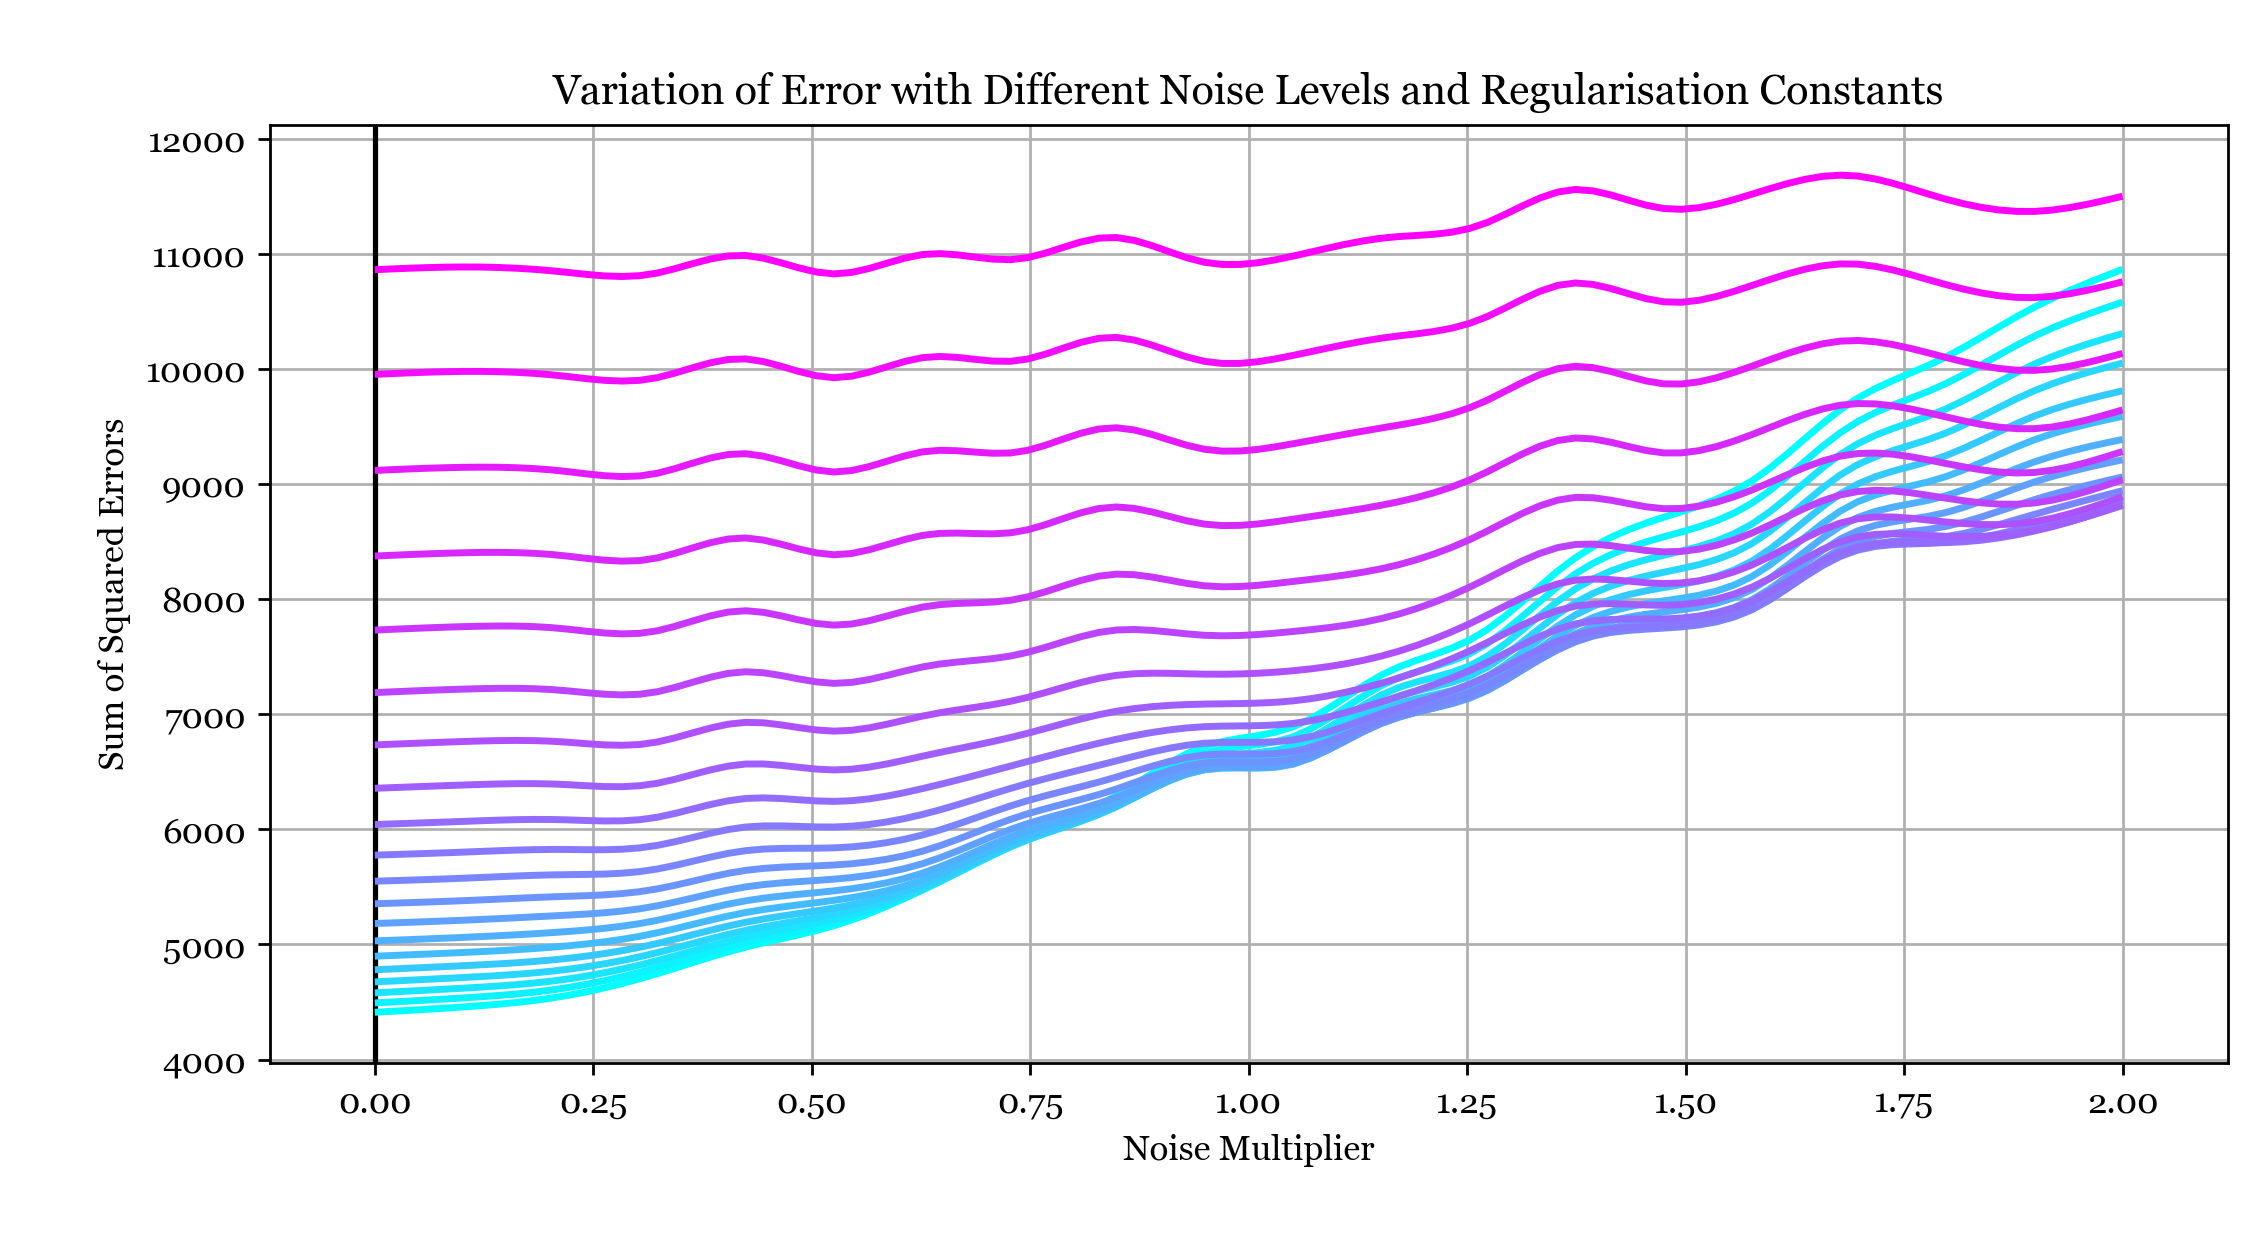

(3974.820442309335, 12117.875931701274)

In [201]:
fig, ax = plt.subplots(1, 1, num=12, figsize=(9,5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.12, right=0.99)
sf3utility.setup_phase_portrait( ax )

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )


xx = np.broadcast_to( noise_levels, (20, 20) )
yy = errors

interpolant = scipy.interpolate.make_interp_spline( noise_levels, yy, axis=1, bc_type="natural" )

xxint = np.linspace( min(noise_levels), max(noise_levels), num=100 )
yyint = interpolant( xxint )
xxint = np.broadcast_to( xxint, (20, 100) )

segments = np.stack( (xxint, yyint), axis=2 )

linecollection = matplotlib.collections.LineCollection( segments, colors=colours, linewidths=2 )

ax.add_collection( linecollection )

ax.set_title( "Variation of Error with Different Noise Levels and Regularisation Constants" )
ax.set_xlabel( "Noise Multiplier" )
ax.set_ylabel( "Sum of Squared Errors" )

centerx = (np.max(xx) + np.min(xx)) / 2
centery = (np.max(yy) + np.min(yy)) / 2

ax.set_xlim( centerx - (centerx - np.min(xx)) * 1.12, centerx + (np.max(xx) - centerx) * 1.12 )
ax.set_ylim( centery - (centery - np.min(yy)) * 1.12, centery + (np.max(yy) - centery) * 1.12 )


Above I have plotted the sum of squared errors against varying observation noise level for the nonlinear model, where each line is a different regularisation constant. The regularisation constants vary logarithmically from $2^{-4}$ in cyan to $2^{3}$ in magenta. As indicated by the gradient along the locus of the lowest points of the curves, the lowest line on the graph depends on the noise level - in other words, the optimal regularisation constant increases as the noise level increases. We know from Gaussian Process theory that the regularisation constant is the variance of the noise, so this matches up well.